In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from string import punctuation
import numpy as np
import pandas as pd
import pickle, re

## Imports
import torch
import torch.nn as nn
import torch.optim as optim

## Embeddings
from flair.data import Sentence
from flair.embeddings import FlairEmbeddings
from flair.embeddings import BertEmbeddings
import allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids

## Ploting
%matplotlib inline
from torch.nn.functional import interpolate
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## NLP Libs
import gensim
from nltk import download
from nltk.corpus import stopwords
import spacy
import en_core_web_sm
spacy_en = en_core_web_sm.load()

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
embed_type = 'bert'
file_embeds = {
    'elmo':   'nips_2018_elmo.pkl',
    'flair':  'nips_2018.pkl',
    'bert':   'nips_2018_bert.pkl'
}

In [3]:
with open(file_embeds[embed_type], "rb") as f:
    nips_2018_dataframe, embeddings_papers = pickle.load(f)
if embeddings_papers.requires_grad:
    embeddings_papers = embeddings_papers.detach()

In [4]:
nips_2018_dataframe.head()

,title,abstract,clean_field
0,Efficient Algorithms for Non-convex Isotonic R...,We consider the minimization of submodular fun...,efficient algorithms non convex isotonic regre...
1,Structure-Aware Convolutional Neural Networks,Convolutional neural networks (CNNs) are inher...,structure aware convolutional neural networks ...
2,Kalman Normalization: Normalizing Internal Rep...,"As an indispensable component, Batch Normaliza...",kalman normalization normalizing internal repr...
3,HOGWILD!-Gibbs can be PanAccurate,Asynchronous Gibbs sampling has been recently ...,hogwild gibbs panaccurate asynchronous gibbs s...
4,Text-Adaptive Generative Adversarial Networks:...,This paper addresses the problem of manipulati...,text adaptive generative adversarial networks ...


In [5]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [6]:
def clean_title(x):
    x = str(x).replace("<b>","").replace("</b>","")
    x = x.replace("-"," ")
    x = strip_punctuation(x)
    x = x.lower()
    return x

In [7]:
nips_2018_dataframe['clean_field'] = nips_2018_dataframe['title'] + ' ' + nips_2018_dataframe['abstract']
nips_2018_dataframe['clean_field'] = nips_2018_dataframe['clean_field'].apply(lambda x: clean_title(x))
nips_2018_dataframe['clean_field'][1008]

'groupreduce block wise low rank approximation for neural language model shrinking model compression is essential for serving large deep neural nets on devices with limited resources or applications that require real time responses for advanced nlp problems a neural language model usually consists of recurrent layers eg using lstm cells an embedding matrix for representing input tokens and a softmax layer for generating output tokens for problems with a very large vocabulary size the embedding and the softmax matrices can account for more than half of the model size for instance the biglstm model achieves state of the art performance on the one billion word obw dataset with around 800k vocabulary and its word embedding and softmax matrices use more than 6gbytes space and are responsible for over 90 of the model parameters in this paper we propose groupreduce a novel compression method for neural language models based on vocabulary partition block based low rank matrix approximation and

In [8]:
nips_2018_dataframe['title'][1008]

'GroupReduce: Block-Wise Low-Rank Approximation for Neural Language Model Shrinking'

## Transform text

In [9]:
def transformText(text, do_stop=False, do_stem=False, do_lemma=True):
    stops = set(stopwords.words("english"))
    # Convert text to lower
    text = text.lower()

    # Cleaning input
    text = text.replace("'s","")
    text = text.replace("’s","")
    text = text.replace("?"," questionmark")
    text = text.replace("-","")
    text = text.replace("''","'")
    text = text.replace("’","'")
    text = text.replace("`","'")
    text = text.replace("’’","'")
    text = text.replace("``","'")
    text = text.replace("'","")

    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Removing all the stopwords
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    if (do_stem==True):
        # Stemming
        text = gensim.parsing.preprocessing.stem_text(text)
    if (do_lemma==True):
        # Lemmatization
        text = do_lemmatization(text)
    return text

def do_lemmatization(text):        
    sent = []
    doc = spacy_en(text)
    for word in doc:
        if word.lemma_ == "-PRON-":
            sent.append(word.text)
        else:
            sent.append(word.lemma_)
    return " ".join(sent)

def strip_punctuation(s):
    return ''.join(c for c in s if c not in PUNCT)

In [10]:
bert_embedding = BertEmbeddings()
def get_bert_embedding(sent):
    sentence = Sentence(sent)
    bert_embedding.embed(sentence)
    all_tensors = torch.zeros(bert_embedding.embedding_length)
    for token in sentence:
        all_tensors+=token.embedding
    return all_tensors/len(sentence)
def get_bert_embedding_batch(sent_list):
    size_array = len(sent_list)
    tensor_array = torch.full((len(sent_list), bert_embedding.embedding_length), fill_value = 0)
    for i,sent in tqdm_notebook(enumerate(sent_list)):
        embed = get_bert_embedding(sent)
        tensor_array[i]=embed
    return tensor_array

In [12]:
nips_2018_dataframe['clean_field'] = nips_2018_dataframe['clean_field'].apply(lambda x: transformText(x,do_stop=True,
                                                                                  do_stem=False, 
                                                                                  do_lemma=False))

In [13]:
embeddings_papers_bert = get_bert_embedding_batch(list(nips_2018_dataframe['clean_field'])).detach()
with open("nips_2018_bert.pkl", "wb") as f:
    pickle.dump((nips_2018_dataframe,embeddings_papers_bert),f)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [14]:
## Calculate TSNE
tsne=TSNE(n_components=2, perplexity = 5, method ='barnes_hut',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_papers.numpy()) 

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1009 samples in 0.085s...
[t-SNE] Computed neighbors for 1009 samples in 5.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1009
[t-SNE] Computed conditional probabilities for sample 1009 / 1009
[t-SNE] Mean sigma: 1.385894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.875542
[t-SNE] Error after 1000 iterations: 2.074921


In [140]:
def get_cosine_distance(text_1, text_2):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    cos_sim = cos(text_1, text_2)
    return cos_sim.detach().numpy()

In [142]:
get_cosine_distance(embeddings_papers[1],embeddings_papers[2])

array(0.9413362, dtype=float32)

In [145]:
### Get distance function
def calculate_nearest_paper(query_text, topn=5, query_type='full'):
    text_distances = pd.DataFrame(columns=['Paper Title', 'Distance', 'index'])
    if embed_type == 'flair':
        query_embedding = get_flair_embedding(query_text)
    elif embed_type == 'elmo':
        query_embedding = get_elmo(query_text)
    elif embed_type == 'bert':
        query_embedding = get_bert_embedding(query_text)
    for i, txt in enumerate(range(len(nips_2018_dataframe))):
        dist = get_cosine_distance(query_embedding,embeddings_papers[i])
        text_distances.loc[i]=[nips_2018_dataframe['title'][i].split('.')[0],dist, i]
    total_dist = text_distances
    text_distances= text_distances.sort_values(by=['Distance'], ascending = False).reset_index(drop=True)[0:topn]
    return text_distances, total_dist

In [281]:
num_papers = 10

In [282]:
ix = np.random.choice(len(nips_2018_dataframe))
#ix = 0
print("{} - {}".format(ix, nips_2018_dataframe['title'][ix]))
nearest_papers, tot = calculate_nearest_paper(nips_2018_dataframe['clean_field'][ix], topn=num_papers)
nearest_papers.head()

252 - Optimal Algorithms for Non-Smooth Distributed Optimization in Networks


,Paper Title,Distance,index
0,Optimal Algorithms for Non-Smooth Distributed ...,1.0,252
1,Uniform Convergence of Gradients for Non-Conve...,0.9666944,804
2,Stochastic Composite Mirror Descent: Optimal B...,0.96372837,138
3,Smoothed analysis of the low-rank approach for...,0.963696,209
4,Adaptive Negative Curvature Descent with Appli...,0.9635349,447


In [283]:
tot.sort_values(by=['Distance'], ascending = True)[0:5]

,Paper Title,Distance,index
340,Unsupervised Attention-guided Image-to-Image T...,0.83139545,340
351,Data center cooling using model-predictive con...,0.84152925,351
608,Contamination Attacks and Mitigation in Multi-...,0.842144,608
180,Universal Growth in Production Economies,0.84866613,180
911,Uplift Modeling from Separate Labels,0.85091597,911


In [284]:
### Get distance function
def calculate_random_paper(samp_size):
    random_sample = np.random.choice(len(embeddings_papers), size = samp_size)
    random_papers_df = pd.DataFrame(columns=['Paper Title', 'index'])
    for i, ix in enumerate(random_sample):
        random_papers_df.loc[i] = [nips_2018_dataframe['title'][ix], ix ]
    return random_papers_df

In [286]:
random_papers = calculate_random_paper(num_papers)
random_papers.tail()

,Paper Title,index
5,Improving Explorability in Variational Inferen...,891
6,Neural Architecture Search with Bayesian Optim...,185
7,Training Deep Neural Networks with 8-bit Float...,707
8,Variational PDEs for Acceleration on Manifolds...,349
9,Temporal alignment and latent Gaussian process...,958


## Diverse Papers

In [287]:
from numpy.random import rand, randn
from scipy.linalg import qr
from numpy import linalg as LA
from dppy.finite_dpps import FiniteDPP

In [288]:
def get_diverse_papers(samp_size, total_samp = 10):
    eig_vecs, _ = qr(embeddings_papers)
    eigenvals_sentences  = LA.eigvals(eig_vecs).astype('float64')
    DPP = FiniteDPP(kernel_type='likelihood',
                **{'L': (eig_vecs * eigenvals_sentences).dot(eig_vecs.T)})
    
    DPP.flush_samples()
    for _ in range(total_samp):
        DPP.sample_exact_k_dpp(size=samp_size)
    rand_sample = np.random.choice(len(DPP.list_of_samples))
    diverse = DPP.list_of_samples[rand_sample]
    diverse_papers_df = pd.DataFrame(columns=['Paper Title', 'index'])
    for i, ix in enumerate(diverse):
        diverse_papers_df.loc[i] = [nips_2018_dataframe['title'][ix], ix ]
    return diverse_papers_df

In [289]:
diverse_papers = get_diverse_papers(num_papers)
diverse_papers.tail()

,Paper Title,index
5,A convex program for bilinear inversion of spa...,787
6,Breaking the Activation Function Bottleneck th...,713
7,"Learning to Play With Intrinsically-Motivated,...",772
8,Reparameterization Gradient for Non-differenti...,512
9,Porcupine Neural Networks: Approximating Neura...,445


In [290]:
def plot_altair_df(dataframe, plot_labels = True):
    import altair as alt
    from vega_datasets import data
    alt.renderers.enable('notebook')
    
    sentences_pd = pd.DataFrame(data = sentences_tsne, columns=['X','Y'])
    ## Concat Array
    dataframe_array = np.full((len(dataframe['index']),sentences_tsne.shape[1]), 5).astype('float32')
    for i, point in enumerate(list(dataframe['index'])):
        dataframe_array[i] = sentences_tsne[point]
    dataframe_pd = pd.DataFrame(data = dataframe_array, columns=['X','Y'])
    dataframe_pd = pd.concat([dataframe_pd, dataframe['Paper Title']], axis = 1)

    ## Plot Arrays
    chart_1 = alt.Chart(
        sentences_pd,
        width=900,
        height=400).mark_circle(
        opacity=0.4, 
        color='red',
        size=20).encode(
        x='X',
        y='Y')
    chart_2 = alt.Chart(dataframe_pd,
            width=900,
            height=400).mark_point(
            color='blue',
            size=30).encode(
            x='X',
            y='Y')
    text = chart_2.mark_text(
        fontSize = 10,
        align='left',
        angle = 5,
        baseline='middle',
        dx=2, 
        dy=20).encode( text='Paper Title')
    
    if plot_labels:
        chart_2 = chart_2+text
    return chart_1 + chart_2   

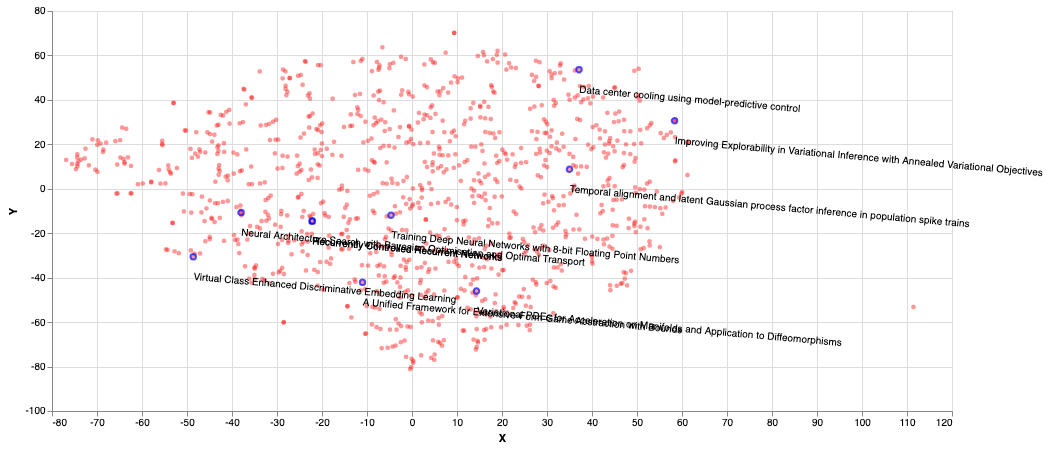

In [291]:
plot_altair_df(random_papers)

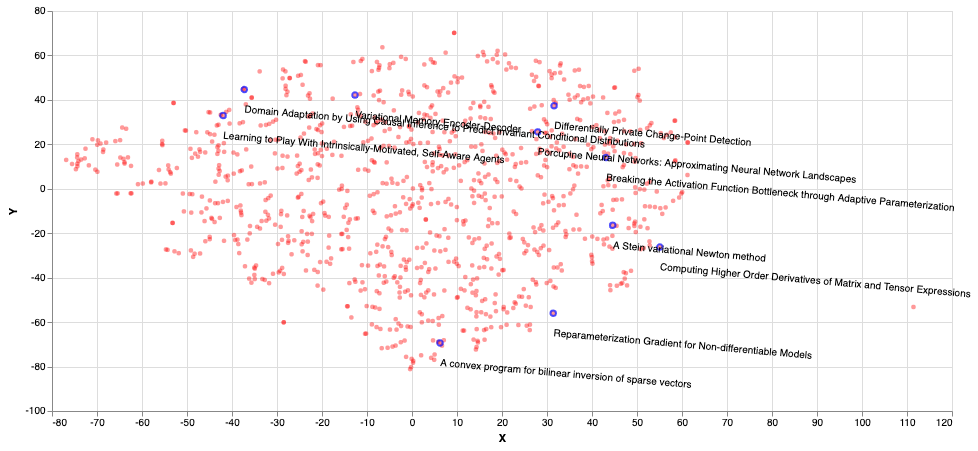

In [292]:
plot_altair_df(diverse_papers)

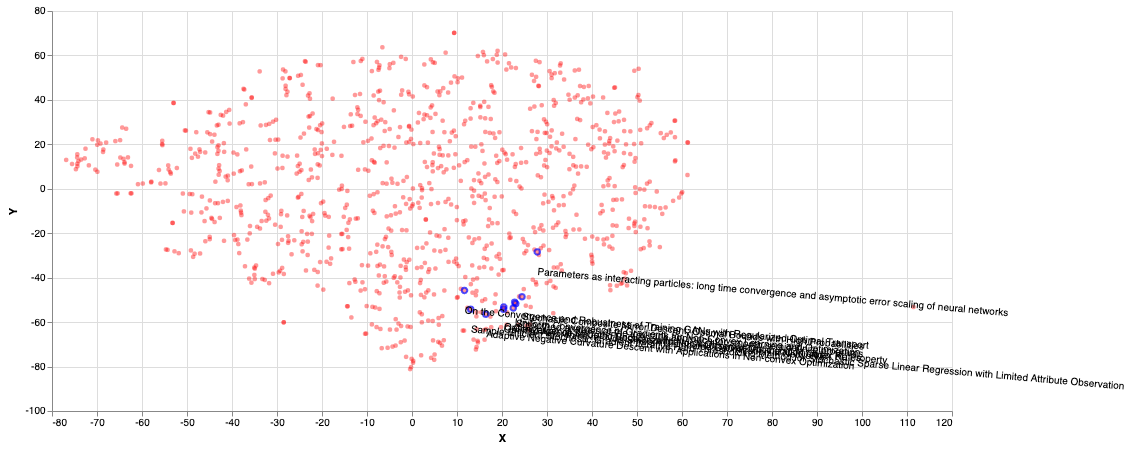

In [293]:
plot_altair_df(nearest_papers)

## Measuring Jaccard Distance of documents

In [294]:
from scipy.stats import entropy
import itertools

In [295]:
def return_np_array(dataframe):
    dataframe_array = np.full((dataframe.shape[0],2), 5).astype('float32')
    for i, point in enumerate(list(dataframe['index'])):
        dataframe_array[i] = sentences_tsne[point]
    return dataframe_array

In [296]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [297]:
def calculate_average(dataframe, metric = 'jaccard'):
    ix = dataframe['index']
    comb = itertools.combinations(ix,2)
    total_dist = 0
    i=0
    for x,y in comb:
        if metric == 'jaccard':
            dist = get_jaccard_sim(nips_2018_dataframe.clean_field.loc[x], nips_2018_dataframe.clean_field.loc[y])
            total_dist += dist
        elif metric == 'cosine':
            dist = get_cosine_distance(embeddings_papers[x],embeddings_papers[y])
            total_dist += dist
        elif metric == 'euclidean':
            dist = distance.euclidean(embeddings_papers[x],embeddings_papers[y])
            total_dist += dist
        i+=1
    return np.mean(total_dist)/i

In [298]:
print("JACCARD DISTANCES ---")
print("RANDOM:  {}".format(calculate_average(random_papers)))
print("DIVERSE: {}".format(calculate_average(diverse_papers)))
print("NEAREST: {}".format(calculate_average(nearest_papers)))

JACCARD DISTANCES ---
RANDOM:  0.05467486020230477
DIVERSE: 0.029904447611087424
NEAREST: 0.08586609104836464


In [299]:
print("COSINE DISTANCES ---")
print("RANDOM:  {}".format(calculate_average(random_papers, metric = 'cosine')))
print("DIVERSE: {}".format(calculate_average(diverse_papers, metric = 'cosine')))
print("NEAREST: {}".format(calculate_average(nearest_papers, metric = 'cosine')))

COSINE DISTANCES ---
RANDOM:  0.9172407269477845
DIVERSE: 0.9103946460617913
NEAREST: 0.9593917515542773


In [300]:
print("COSINE DISTANCES ---")
print("RANDOM:  {}".format(calculate_average(random_papers, metric = 'euclidean')))
print("DIVERSE: {}".format(calculate_average(diverse_papers, metric = 'euclidean')))
print("NEAREST: {}".format(calculate_average(nearest_papers, metric = 'euclidean')))

COSINE DISTANCES ---
RANDOM:  10.352695677015516
DIVERSE: 10.980364990234374
NEAREST: 7.132059065500895
